In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import networkx as nx

from rdkit import Chem
from rdkit.Chem import Draw

# import torch_geometric.data into environment
from torch_geometric.data import Data
from torch_geometric.datasets import MoleculeNet
from torch_geometric import nn
import torch_geometric.transforms as T
from torch_geometric.nn import GATv2Conv

from torch_geometric.nn.pool import global_mean_pool

from torch.utils.data import random_split

from torch_geometric.loader import DataLoader

from utils import DrawMolToMPL

from pysmiles import read_smiles #Unused

from tqdm import tqdm

from time import time

# check if GPU is available and detectable. cpu is ok for this homework.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [398]:
class OneHotTransform:
    def __init__(self, untransformed):
        self.full_x = untransformed.x
        self.full_x_slices = untransformed.slices['x']
        self.full_edges = untransformed.edge_attr
        self.full_edge_slices = untransformed.slices["edge_index"]
        
        self.index = 0
        self.edge_index = 0

    def __call__(self, data: Data):
        tensors = []
        for i in range(self.full_x.shape[1]):
            unique, unique_indices = torch.unique(self.full_x[:, i], return_inverse = True)

            if len(unique) > 2:
                tensors.append(F.one_hot(unique_indices, len(unique)))
            elif len(unique) == 2:
                tensors.append(self.full_x[:, i].reshape(-1, 1))

        new_x = torch.cat(tensors, dim = 1)

        start = self.full_x_slices[self.index]
        end = self.full_x_slices[self.index + 1]
        data.x = new_x[start:end]


        tensors = []
        for i in range(self.full_edges.shape[1]):
            unique, unique_indices = torch.unique(self.full_edges[:, i], return_inverse = True)

            if len(unique) > 2:
                tensors.append(F.one_hot(unique_indices, len(unique)))
            elif len(unique) == 2:
                tensors.append(self.full_edges[:, i].reshape(-1, 1))

        new_edges = torch.cat(tensors, dim = 1)

        start = self.full_edge_slices[self.index]
        end = self.full_edge_slices[self.index + 1]
        data.edge_attr = new_edges[start:end]

        self.index += 1

        return data

In [399]:
dataset_name = "ESOL"
dataset_untransformed = MoleculeNet('./data', dataset_name)

c:\Users\mrwun\anaconda3\envs\geometric\Lib\site-packages\torch_geometric\data\dataset.py:240: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(


In [400]:
dataset_untransformed.slices

{'x': tensor([    0,    32,    47,  ..., 14967, 14972, 14991]),
 'edge_index': tensor([    0,    68,   100,  ..., 30810, 30818, 30856]),
 'edge_attr': tensor([    0,    68,   100,  ..., 30810, 30818, 30856]),
 'smiles': tensor([   0,    1,    2,  ..., 1126, 1127, 1128]),
 'y': tensor([   0,    1,    2,  ..., 1126, 1127, 1128])}

In [401]:
tensors = []
for i in range(dataset_untransformed.x.shape[1]):
    print(f"Unique values, column {i}")
    unique, unique_indices = torch.unique(dataset_untransformed.x[:, i], return_inverse = True)
    print(unique)
    print(len(unique))

    if len(unique) > 2:
        tensors.append(F.one_hot(unique_indices, len(unique)))
    elif len(unique) == 2:
        tensors.append(dataset_untransformed.x[:, i].reshape(-1, 1))

new_x = torch.cat(tensors, dim = 1)
print(new_x.shape)

print("Atomic number (one-hot), chirality (one-hot), degree (one-hot), valence (one-hot), number of bonded hydrogens (one-hot), number of radicals (omitted), hybridization (one-hot), aromatic, in ring")

edge_tensors = []
for i in range(dataset_untransformed.edge_attr.shape[1]):
    print(f"Unique values, column {i}")
    unique, unique_indices = torch.unique(dataset_untransformed.edge_attr[:, i], return_inverse = True)
    print(unique)
    print(len(unique))

    if len(unique) > 2:
        edge_tensors.append(F.one_hot(unique_indices, len(unique)))
    elif len(unique) == 2:
        edge_tensors.append(dataset_untransformed.edge_attr[:, i].reshape(-1, 1))

new_x = torch.cat(edge_tensors, dim = 1)
print(new_x.shape)

print("Aromaticity, bond stereochemistry, conjugation")

Unique values, column 0
tensor([0, 1])
2
Unique values, column 1
tensor([0, 1])
2
Unique values, column 2
tensor([0, 1])
2
Unique values, column 3
tensor([0, 1])
2
Unique values, column 4
tensor([0, 1])
2
Unique values, column 5
tensor([0, 1])
2
Unique values, column 6
tensor([0, 1])
2
Unique values, column 7
tensor([0, 1])
2
Unique values, column 8
tensor([0, 1])
2
Unique values, column 9
tensor([0, 1])
2
Unique values, column 10
tensor([0, 1])
2
Unique values, column 11
tensor([0, 1])
2
Unique values, column 12
tensor([0, 1])
2
Unique values, column 13
tensor([0, 1])
2
Unique values, column 14
tensor([0, 1])
2
Unique values, column 15
tensor([0, 1])
2
Unique values, column 16
tensor([0, 1])
2
Unique values, column 17
tensor([0, 1])
2
Unique values, column 18
tensor([0, 1])
2
Unique values, column 19
tensor([0, 1])
2
Unique values, column 20
tensor([0, 1])
2
Unique values, column 21
tensor([0, 1])
2
Unique values, column 22
tensor([0, 1])
2
Unique values, column 23
tensor([0, 1])
2
Un

In [402]:

dataset = MoleculeNet('./data', dataset_name, pre_transform = OneHotTransform(dataset_untransformed), force_reload = True)

Processing...
Done!


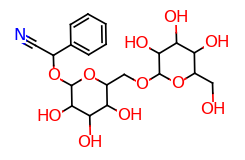

In [403]:
def draw_smiles(smiles_string, fig = None, ax = None):
    molecule = Chem.MolFromSmiles(smiles_string)

    if fig == None:
        fig = plt.gcf()
    if ax == None:
        ax = fig.gca()
    
    DrawMolToMPL(molecule, fig, ax)

fig = plt.figure()
ax = plt.subplot(121)
draw_smiles(dataset[0].smiles)
plt.show()

In [404]:
dataset[1].edge_attr

tensor([[1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 1],
        [0, 0, 0, 1, 1, 0, 0, 1],
        [0, 0, 0, 1, 1, 0, 0, 1],
        [0, 0, 0, 1, 1, 0, 0, 1],
        [0, 0, 0, 1, 1, 0, 0, 1],
        [0, 0, 0, 1, 1, 0, 0, 1],
        [0, 0, 0, 1, 1, 0, 0, 1],
        [0, 0, 0, 1, 1, 0, 0, 1],
        [0, 0, 0, 1, 1, 0, 0, 1],
        [0, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 1],
        [0, 1, 0, 0, 1, 0, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 1],
        [0, 1, 0, 0, 1, 0, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 1],
        [0, 0, 0, 1, 1, 0, 0, 1],
        [0, 0, 0, 1, 1, 0, 0, 1],
        [0, 0, 0, 1, 1, 0, 0, 1],
        [0, 0, 0, 1, 1, 0, 0, 1],
        [0, 0, 0, 1, 1, 0, 0, 1],
        [0, 0, 0, 1, 1, 0, 0, 1],
        [0, 0, 0, 1, 1, 0, 0, 1],
        [0, 0, 0, 1, 1, 0, 0, 1],
        [0, 0, 0, 1, 1, 0, 0, 1],
        [0, 0,

In [405]:

dataset_size = len(dataset)
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f"Train dataset: {len(train_dataset)} graphs")
print(f"Val dataset: {len(val_dataset)} graphs")
print(f"Test dataset: {len(test_dataset)} graphs")

Train dataset: 676 graphs
Val dataset: 225 graphs
Test dataset: 227 graphs


In [406]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, edge_dim, heads=8, dropout=0.2):
        super(GAT, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads=heads, dropout=dropout, edge_dim = edge_dim)
        self.relu = torch.nn.ReLU()
        self.conv2 = GATv2Conv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout, edge_dim = edge_dim)
        self.conv3 = GATv2Conv(hidden_channels * heads, in_channels, heads=1, dropout=dropout, edge_dim = edge_dim)

        self.conv_single = GATv2Conv(in_channels, in_channels, heads = 1, dropout = dropout, edge_dim = edge_dim)
        self.linear_1 = torch.nn.Linear(in_channels, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.edge_attr
        attn_weights = [None] * 3
        x, attn_weights[0] = self.conv1(x, edge_index, edge_attr = edge_attr, return_attention_weights= True)
        x = self.relu(x)
        x, attn_weights[1] = self.conv2(x, edge_index, edge_attr = edge_attr,  return_attention_weights= True)
        x = self.relu(x)
        x, attn_weights[2] = self.conv3(x, edge_index, edge_attr = edge_attr,  return_attention_weights= True)
        
        #x, attn_weights[0] = self.conv_single(x, edge_index, edge_attr = edge_attr, return_attention_weights= True)

        x = self.relu(x)
        x = self.linear_1(x)
        x = nn.pool.global_mean_pool(x, data.batch)
        return x, attn_weights

In [407]:
import sys
test_loader = DataLoader(train_dataset, shuffle = False, batch_size = 2)


in_dimensions = dataset.x.shape[1]
edge_dimensions = dataset.edge_attr.shape[1]
print(in_dimensions)
print(edge_dimensions)
model = GAT(in_dimensions, 60, edge_dimensions)
print(train_dataset[0].x.dtype)
print(train_dataset[0].x)
i = next(iter(test_loader))
y_pred, attn = model(i)
print(y_pred)

26
8
torch.int64
tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
         0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
         0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
         0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
         0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
         0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
         0, 0]])
tensor([[0.0122],
        [0.0110]], grad_fn=<DivBackward0>)


In [408]:
def train(model, loader, optimizer, loss_fn, epoch_no):
    epoch_loss = 0
    model.train()

    epoch_iter = tqdm(loader, desc = "Train", ncols = 130)
    for batch in epoch_iter:
        optimizer.zero_grad()
        y_pred, _ = model(batch)

        loss = loss_fn(y_pred, batch.y)


        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_iter.set_description(f"epoch: {epoch_no}, train_loss: {loss:.4f}")


    return epoch_loss/len(loader)


@torch.no_grad()
def test(model, loader, loss_fn):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch in tqdm(loader, ncols = 130, desc = "Eval"):
            y_pred, _ = model(batch)
            loss = loss_fn(y_pred, batch.y)

            epoch_loss += loss.item()
    
    return epoch_loss/len(loader)   

In [409]:
EPOCHS = 40
BATCH_SIZE = 20

in_dimensions = dataset.x.shape[1]
print(in_dimensions)
model = GAT(in_dimensions, in_dimensions * 2, edge_dimensions)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fn = torch.nn.MSELoss()


train_loader = DataLoader(train_dataset, shuffle = True, batch_size = BATCH_SIZE)
val_loader = DataLoader(val_dataset, shuffle = True, batch_size = BATCH_SIZE)

all_epochs = np.arange(EPOCHS)
all_train_loss = []
all_val_loss = []

for epoch in all_epochs:

    start_time = time()  # record the start time

    train_loss = train(model, train_loader, optimizer, loss_fn, epoch)
    all_train_loss.append(train_loss)

    end_time = time()

    epoch_time = end_time - start_time

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_time}s')
    print(f'\tTrain Loss: {train_loss:.3f}')

    val_loss = test(model, val_loader, loss_fn)
    all_val_loss.append(val_loss)
    print(f'Val Loss: {val_loss:.3f}')




26


epoch: 0, train_loss: 3.5753: 100%|███████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.27it/s]


Epoch: 01 | Epoch Time: 3.667416572570801s
	Train Loss: 6.192


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 30.53it/s]


Val Loss: 3.869


epoch: 1, train_loss: 2.4246: 100%|███████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.02it/s]


Epoch: 02 | Epoch Time: 2.2757067680358887s
	Train Loss: 3.836


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 67.70it/s]


Val Loss: 3.323


epoch: 2, train_loss: 3.3576: 100%|███████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 18.19it/s]


Epoch: 03 | Epoch Time: 1.883380651473999s
	Train Loss: 3.387


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 62.42it/s]


Val Loss: 3.223


epoch: 3, train_loss: 2.3094: 100%|███████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 17.48it/s]


Epoch: 04 | Epoch Time: 1.944812297821045s
	Train Loss: 2.957


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 42.58it/s]


Val Loss: 2.952


epoch: 4, train_loss: 2.0605: 100%|███████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.79it/s]


Epoch: 05 | Epoch Time: 1.7193388938903809s
	Train Loss: 2.429


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.53it/s]


Val Loss: 2.696


epoch: 5, train_loss: 2.6466: 100%|███████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 16.47it/s]


Epoch: 06 | Epoch Time: 2.067047357559204s
	Train Loss: 2.176


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 43.14it/s]


Val Loss: 2.269


epoch: 6, train_loss: 1.0925: 100%|███████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 16.74it/s]


Epoch: 07 | Epoch Time: 2.033907651901245s
	Train Loss: 2.066


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.97it/s]


Val Loss: 2.096


epoch: 7, train_loss: 1.3517: 100%|███████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.30it/s]


Epoch: 08 | Epoch Time: 2.764535903930664s
	Train Loss: 1.779


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 39.79it/s]


Val Loss: 2.073


epoch: 8, train_loss: 1.8520: 100%|███████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.56it/s]


Epoch: 09 | Epoch Time: 1.7392959594726562s
	Train Loss: 1.595


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.27it/s]


Val Loss: 2.082


epoch: 9, train_loss: 1.5560: 100%|███████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 22.58it/s]


Epoch: 10 | Epoch Time: 1.5167818069458008s
	Train Loss: 1.421


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 63.76it/s]


Val Loss: 1.516


epoch: 10, train_loss: 1.0719: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 23.12it/s]


Epoch: 11 | Epoch Time: 1.4788382053375244s
	Train Loss: 1.363


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 52.07it/s]


Val Loss: 1.425


epoch: 11, train_loss: 1.2373: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 22.36it/s]


Epoch: 12 | Epoch Time: 1.5235066413879395s
	Train Loss: 1.311


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.17it/s]


Val Loss: 2.039


epoch: 12, train_loss: 0.7371: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.88it/s]


Epoch: 13 | Epoch Time: 1.7180936336517334s
	Train Loss: 1.263


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 55.97it/s]


Val Loss: 1.158


epoch: 13, train_loss: 0.6160: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 20.09it/s]


Epoch: 14 | Epoch Time: 1.7080185413360596s
	Train Loss: 1.174


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 35.39it/s]


Val Loss: 1.231


epoch: 14, train_loss: 0.7777: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 18.75it/s]


Epoch: 15 | Epoch Time: 1.8136367797851562s
	Train Loss: 1.067


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.93it/s]


Val Loss: 1.445


epoch: 15, train_loss: 1.2829: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 22.31it/s]


Epoch: 16 | Epoch Time: 1.525123119354248s
	Train Loss: 1.067


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.35it/s]


Val Loss: 1.144


epoch: 16, train_loss: 1.9767: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 23.37it/s]


Epoch: 17 | Epoch Time: 1.454700231552124s
	Train Loss: 0.970


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.15it/s]


Val Loss: 1.064


epoch: 17, train_loss: 1.4300: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 21.35it/s]


Epoch: 18 | Epoch Time: 1.5923855304718018s
	Train Loss: 0.953


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.53it/s]


Val Loss: 0.923


epoch: 18, train_loss: 0.8622: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 22.42it/s]


Epoch: 19 | Epoch Time: 1.5165834426879883s
	Train Loss: 0.901


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.88it/s]


Val Loss: 0.905


epoch: 19, train_loss: 0.2335: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.74it/s]


Epoch: 20 | Epoch Time: 2.311971664428711s
	Train Loss: 0.850


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.06it/s]


Val Loss: 0.990


epoch: 20, train_loss: 0.5688: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.61it/s]


Epoch: 21 | Epoch Time: 2.327321767807007s
	Train Loss: 0.834


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 41.90it/s]


Val Loss: 0.949


epoch: 21, train_loss: 0.7780: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.01it/s]


Epoch: 22 | Epoch Time: 2.271366596221924s
	Train Loss: 0.841


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 43.35it/s]


Val Loss: 1.014


epoch: 22, train_loss: 0.7413: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 16.98it/s]


Epoch: 23 | Epoch Time: 2.002047538757324s
	Train Loss: 0.940


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.52it/s]


Val Loss: 0.877


epoch: 23, train_loss: 1.0336: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 22.43it/s]


Epoch: 24 | Epoch Time: 1.5265448093414307s
	Train Loss: 0.836


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.17it/s]


Val Loss: 0.875


epoch: 24, train_loss: 1.2838: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 23.09it/s]


Epoch: 25 | Epoch Time: 1.4722208976745605s
	Train Loss: 0.817


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 55.18it/s]


Val Loss: 1.028


epoch: 25, train_loss: 0.5057: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 21.44it/s]


Epoch: 26 | Epoch Time: 1.5860745906829834s
	Train Loss: 0.720


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.45it/s]


Val Loss: 0.990


epoch: 26, train_loss: 0.3048: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 22.89it/s]


Epoch: 27 | Epoch Time: 1.4861280918121338s
	Train Loss: 0.786


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 69.72it/s]


Val Loss: 0.854


epoch: 27, train_loss: 0.7204: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 22.73it/s]


Epoch: 28 | Epoch Time: 1.497504711151123s
	Train Loss: 0.775


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 65.87it/s]


Val Loss: 0.904


epoch: 28, train_loss: 0.3990: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 23.01it/s]


Epoch: 29 | Epoch Time: 1.4935543537139893s
	Train Loss: 0.691


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.98it/s]


Val Loss: 1.126


epoch: 29, train_loss: 0.8766: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 23.55it/s]


Epoch: 30 | Epoch Time: 1.44590163230896s
	Train Loss: 0.701


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 65.26it/s]


Val Loss: 0.713


epoch: 30, train_loss: 0.7414: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 22.25it/s]


Epoch: 31 | Epoch Time: 1.5363996028900146s
	Train Loss: 0.712


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 67.07it/s]


Val Loss: 0.752


epoch: 31, train_loss: 0.7862: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 22.94it/s]


Epoch: 32 | Epoch Time: 1.4823057651519775s
	Train Loss: 0.707


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.20it/s]


Val Loss: 0.781


epoch: 32, train_loss: 0.7353: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 24.88it/s]


Epoch: 33 | Epoch Time: 1.3668186664581299s
	Train Loss: 0.683


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 65.46it/s]


Val Loss: 0.739


epoch: 33, train_loss: 0.6938: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.36it/s]


Epoch: 34 | Epoch Time: 1.7573585510253906s
	Train Loss: 0.625


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 40.02it/s]


Val Loss: 0.743


epoch: 34, train_loss: 0.7682: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 17.30it/s]


Epoch: 35 | Epoch Time: 1.964768648147583s
	Train Loss: 0.633


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 42.90it/s]


Val Loss: 0.865


epoch: 35, train_loss: 1.2940: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 18.42it/s]


Epoch: 36 | Epoch Time: 1.845581293106079s
	Train Loss: 0.629


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.34it/s]


Val Loss: 0.813


epoch: 36, train_loss: 1.3773: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 22.84it/s]


Epoch: 37 | Epoch Time: 1.4888274669647217s
	Train Loss: 0.699


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 65.37it/s]


Val Loss: 0.958


epoch: 37, train_loss: 0.2756: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.55it/s]


Epoch: 38 | Epoch Time: 1.739227294921875s
	Train Loss: 0.665


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 48.49it/s]


Val Loss: 0.732


epoch: 38, train_loss: 0.4013: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.29it/s]


Epoch: 39 | Epoch Time: 1.7636146545410156s
	Train Loss: 0.629


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 52.11it/s]


Val Loss: 0.756


epoch: 39, train_loss: 0.6392: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 22.78it/s]


Epoch: 40 | Epoch Time: 1.4977750778198242s
	Train Loss: 0.600


Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.95it/s]

Val Loss: 0.725


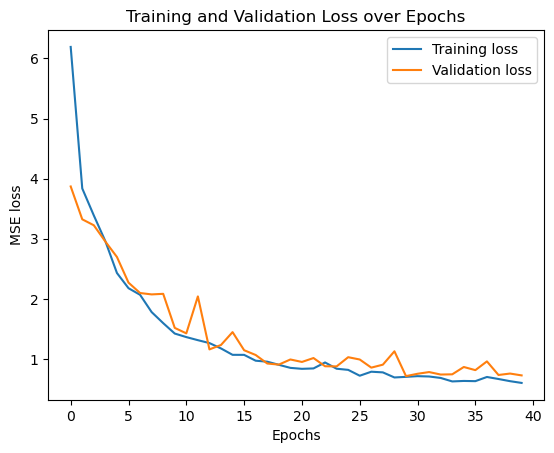

In [410]:
plt.figure()
plt.title("Training and Validation Loss over Epochs")
plt.plot(all_epochs, all_train_loss, label = "Training loss")
plt.plot(all_epochs, all_val_loss, label = "Validation loss")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.legend()

In [411]:
def detailed_predictions(model, loader):
    model.eval()
    epoch_loss = 0

    all_y = []
    all_y_pred = []
    all_inputs = []
    all_attn = []
    with torch.no_grad():
        for batch in tqdm(loader, ncols = 130, desc = "Eval"):
            y_pred, attn = model(batch)
            all_inputs.append(batch)
            all_attn.append(attn)
            loss = loss_fn(y_pred, batch.y)

            epoch_loss += loss.item()

            all_y_pred.append(y_pred.reshape([-1]))
            all_y.append(batch.y.reshape([-1]))
        
        all_y = torch.cat(all_y).numpy()
        all_y_pred = torch.cat(all_y_pred).numpy()

            
    
    return epoch_loss/len(loader), all_inputs, all_y, all_y_pred, all_attn

In [412]:
test_loader = DataLoader(test_dataset, shuffle = True, batch_size = 1)
loss, all_inputs, all_y, all_y_pred, all_attn = detailed_predictions(model, test_loader)

Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████| 227/227 [00:03<00:00, 64.99it/s]


In [413]:
print(loss)

0.7419516909331444


In [414]:
from scipy.stats import linregress

[-6.637 -2.68  -7.28  -2.25  -6.876 -3.23  -4.21  -5.03  -3.78  -1.74
 -1.655 -1.96  -4.8   -3.9   -2.23  -1.45  -6.68   1.144 -2.281  1.34
 -2.35  -7.92  -3.53  -2.1   -4.56  -1.34  -1.3   -1.72  -2.51  -2.73
 -2.55  -3.18  -2.22  -4.07  -4.36  -8.6   -1.01  -0.45  -2.38  -3.
 -1.708 -1.09  -4.445 -1.79  -2.982 -2.33  -2.92  -4.29  -3.05  -4.43
 -7.2    0.15  -2.42  -0.24  -0.28  -8.402 -1.74  -4.345 -5.507 -4.57
 -2.78  -5.696 -2.766 -4.23   0.26  -4.735 -4.19  -4.88   1.57  -2.34
 -5.16  -3.504 -2.273 -3.586  1.02  -4.594  0.38   1.1   -8.057 -3.924
 -1.01  -3.239 -4.678 -2.46  -2.41  -4.4   -1.06  -4.03  -1.62   0.715
 -3.03  -0.667 -9.16  -1.77  -4.755 -3.61  -5.53  -0.24  -4.9   -3.01
 -4.43  -5.27  -0.79  -0.82  -0.15  -6.59  -6.47  -4.08  -2.13  -5.284
 -8.    -0.17  -3.094 -5.24  -4.554 -1.3   -2.12  -7.11  -3.083 -4.7
 -5.752  0.96  -3.59  -4.883 -2.62  -5.666 -0.71  -3.1   -1.54  -3.84
 -1.228  0.29  -2.461 -7.15  -0.88  -4.1    0.28  -3.43  -4.65  -1.33
 -3.19  -2.68  -4.31

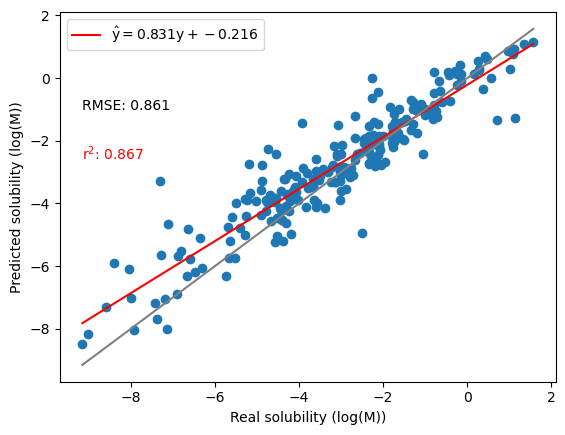

In [415]:
print(all_y)
print(all_y_pred)
plt.scatter(all_y, all_y_pred)

if dataset_name == "ESOL":
    plt.xlabel("Real solubility (log(M))")
    plt.ylabel("Predicted solubility (log(M))")
elif dataset_name == "FreeSolv":
    plt.xlabel("Real solvation free energy (kcal/mol)")
    plt.ylabel("Predicted solvation free energy (kcal/mol)")

x_vals = np.linspace(np.min(all_y), np.max(all_y), 10)

result = linregress(all_y, all_y_pred)
print(all_y)

plt.plot(x_vals, result.slope * x_vals + result.intercept, c = "red", label = r"$\hat{y}=" + f"{result.slope:.3f}y+{result.intercept:.3f}$")

plt.text(min(all_y), (plt.ylim()[1] - plt.ylim()[0]) * 0.75 + plt.ylim()[0], f"RMSE: {np.sqrt(loss):.3f}")
plt.text(min(all_y), (plt.ylim()[1] - plt.ylim()[0]) * 0.6 + plt.ylim()[0], f"$r^2$: {result.rvalue**2:.3f}", c = "red")
plt.legend()
plt.plot(x_vals, x_vals, c = 'grey')

['c1(C(=O)OCCCCCC(C)(C))c(C(=O)OCCCCCC(C)(C))cccc1']


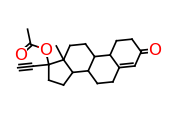

In [416]:
input = all_inputs[12]
plt.figure(figsize=(2, 2))
draw_smiles(input.smiles[0], fig = plt.gcf())
print(all_inputs[0].smiles)

In [417]:
def my_draw_networkx_edge_labels(
        #https://stackoverflow.com/questions/22785849/drawing-multiple-edges-between-two-nodes-with-networkx
    G,
    pos,
    edge_labels=None,
    label_pos=0.5,
    font_size=10,
    font_color="k",
    font_family="sans-serif",
    font_weight="normal",
    alpha=None,
    bbox=None,
    horizontalalignment="center",
    verticalalignment="center",
    ax=None,
    rotate=True,
    clip_on=True,
    rad=0
):
    """Draw edge labels.

    Parameters
    ----------
    G : graph
        A networkx graph

    pos : dictionary
        A dictionary with nodes as keys and positions as values.
        Positions should be sequences of length 2.

    edge_labels : dictionary (default={})
        Edge labels in a dictionary of labels keyed by edge two-tuple.
        Only labels for the keys in the dictionary are drawn.

    label_pos : float (default=0.5)
        Position of edge label along edge (0=head, 0.5=center, 1=tail)

    font_size : int (default=10)
        Font size for text labels

    font_color : string (default='k' black)
        Font color string

    font_weight : string (default='normal')
        Font weight

    font_family : string (default='sans-serif')
        Font family

    alpha : float or None (default=None)
        The text transparency

    bbox : Matplotlib bbox, optional
        Specify text box properties (e.g. shape, color etc.) for edge labels.
        Default is {boxstyle='round', ec=(1.0, 1.0, 1.0), fc=(1.0, 1.0, 1.0)}.

    horizontalalignment : string (default='center')
        Horizontal alignment {'center', 'right', 'left'}

    verticalalignment : string (default='center')
        Vertical alignment {'center', 'top', 'bottom', 'baseline', 'center_baseline'}

    ax : Matplotlib Axes object, optional
        Draw the graph in the specified Matplotlib axes.

    rotate : bool (deafult=True)
        Rotate edge labels to lie parallel to edges

    clip_on : bool (default=True)
        Turn on clipping of edge labels at axis boundaries

    Returns
    -------
    dict
        `dict` of labels keyed by edge

    Examples
    --------
    >>> G = nx.dodecahedral_graph()
    >>> edge_labels = nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G))

    Also see the NetworkX drawing examples at
    https://networkx.org/documentation/latest/auto_examples/index.html

    See Also
    --------
    draw
    draw_networkx
    draw_networkx_nodes
    draw_networkx_edges
    draw_networkx_labels
    """
    import matplotlib.pyplot as plt
    import numpy as np

    if ax is None:
        ax = plt.gca()
    if edge_labels is None:
        labels = {(u, v): d for u, v, d in G.edges(data=True)}
    else:
        labels = edge_labels
    text_items = {}
    for (n1, n2), label in labels.items():
        (x1, y1) = pos[n1]
        (x2, y2) = pos[n2]
        (x, y) = (
            x1 * label_pos + x2 * (1.0 - label_pos),
            y1 * label_pos + y2 * (1.0 - label_pos),
        )
        pos_1 = ax.transData.transform(np.array(pos[n1]))
        pos_2 = ax.transData.transform(np.array(pos[n2]))
        linear_mid = 0.5*pos_1 + 0.5*pos_2
        d_pos = pos_2 - pos_1
        rotation_matrix = np.array([(0,1), (-1,0)])
        ctrl_1 = linear_mid + rad*rotation_matrix@d_pos
        ctrl_mid_1 = 0.5*pos_1 + 0.5*ctrl_1
        ctrl_mid_2 = 0.5*pos_2 + 0.5*ctrl_1
        bezier_mid = 0.5*ctrl_mid_1 + 0.5*ctrl_mid_2
        (x, y) = ax.transData.inverted().transform(bezier_mid)

        if rotate:
            # in degrees
            angle = np.arctan2(y2 - y1, x2 - x1) / (2.0 * np.pi) * 360
            # make label orientation "right-side-up"
            if angle > 90:
                angle -= 180
            if angle < -90:
                angle += 180
            # transform data coordinate angle to screen coordinate angle
            xy = np.array((x, y))
            trans_angle = ax.transData.transform_angles(
                np.array((angle,)), xy.reshape((1, 2))
            )[0]
        else:
            trans_angle = 0.0
        # use default box of white with white border
        if bbox is None:
            bbox = dict(boxstyle="round", ec=(1.0, 1.0, 1.0), fc=(1.0, 1.0, 1.0))
        if not isinstance(label, str):
            label = str(label)  # this makes "1" and 1 labeled the same

        t = ax.text(
            x,
            y,
            label,
            size=font_size,
            color=font_color,
            family=font_family,
            weight=font_weight,
            alpha=alpha,
            horizontalalignment=horizontalalignment,
            verticalalignment=verticalalignment,
            rotation=trans_angle,
            transform=ax.transData,
            bbox=bbox,
            zorder=1,
            clip_on=clip_on,
        )
        text_items[(n1, n2)] = t

    ax.tick_params(
        axis="both",
        which="both",
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False,
    )

    return text_items

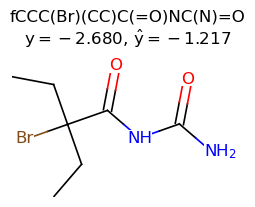

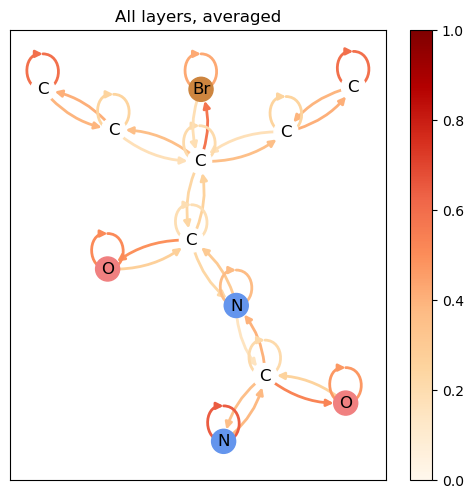

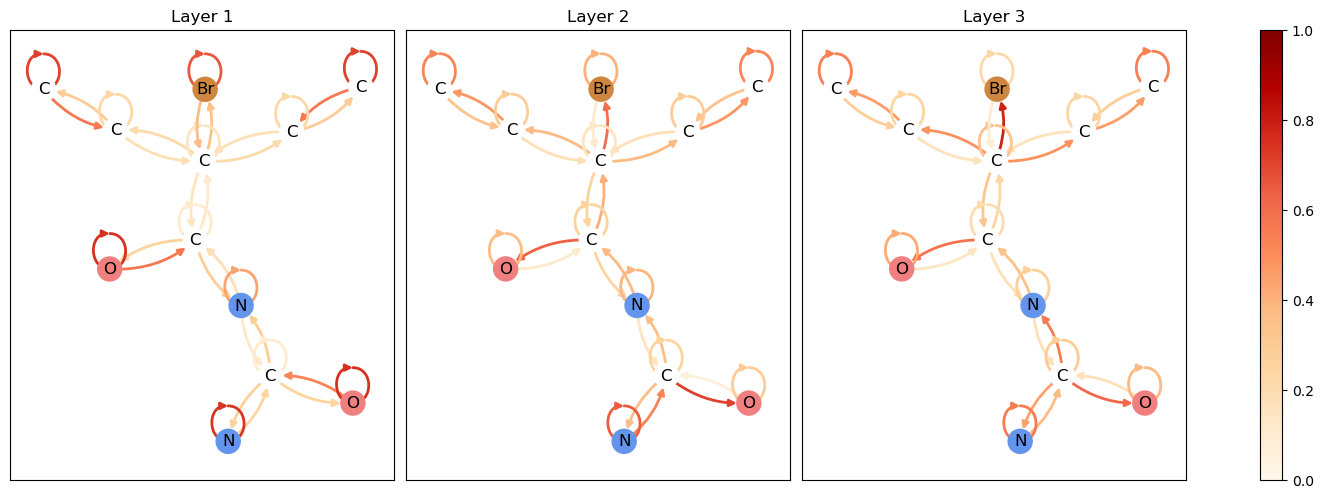

In [421]:
def visualize_attention_map(all_attn, smiles, y, y_hat, rad = 0.2, labels = True, cmap = plt.cm.gist_heat, averaged = False):
    if len(all_attn)  > 1:
        layer_averaged_attn = ((all_attn[0][0], torch.mean((torch.stack([torch.mean(t[1], dim = 1).unsqueeze(0).reshape((-1, 1)) for t in all_attn])), dim = 0)))
        visualize_attention_map([layer_averaged_attn], smiles, y, y_hat, rad, labels, cmap, averaged = True)
    else:
        plt.figure(figsize = (3, 3))
        plt.title(f"f{smiles}\n$y = {y:.3f}$," + r" $\hat{y}" + f" = {y_hat:.3f}$")
        draw_smiles(smiles)
        plt.show()

    plt.figure(figsize = (5 * len(all_attn), 5))
    ax_list = [None] * len(all_attn)
    for i, tup in enumerate(all_attn):
        #plt.suptitle("Averaged Attention Weights")
        ax_list[i] = plt.subplot( 1, len(all_attn), i+1)
        
        if not averaged:
            plt.title(f"Layer {i + 1}")
        else:
            plt.title("All layers, averaged")

        edge_index = tup[0]
        attentions = tup[1]
        #print(tuple)

        averaged_attention = torch.mean(attentions, dim = 1)
        g = read_smiles(smiles).to_directed()

        pos = nx.kamada_kawai_layout(g)
        
        g.add_weighted_edges_from([(edge_index[0, i].item(), edge_index[1, i].item(), averaged_attention[i].item()) for i in range(edge_index.shape[1])])

        
        node_colors = {'C': 'white', 'O': 'lightcoral', 'N': 'cornflowerblue', 'Cl': 'springgreen', 'Br': 'peru'}
        elements = nx.get_node_attributes(g, name = "element")
        edge_weights = nx.get_edge_attributes(g, name = "weight")

        color_map = [node_colors.get(element, 'white') for element in elements.values()]


        nx.draw_networkx_nodes(g, label = elements, pos=pos, node_color = color_map)
        nx.draw_networkx_labels(g, pos, elements)
        #
        #width= (10 * (np.array(list(edge_weights.values()))))
        collection = nx.draw_networkx_edges(g, pos, edge_weights.keys(), edge_color=edge_weights.values(), edge_cmap=cmap, width= 2, arrows = True, connectionstyle=f'arc3, rad = {rad}', edge_vmin = 0, edge_vmax = 1)
        

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0, vmax=1))


        
        if labels:
            my_draw_networkx_edge_labels(g, pos, {i: f"{edge_weights[i]:.2f}" for i in edge_weights.keys()}, rad = rad, rotate = False)
        #plt.gca().set_aspect('equal')

        plt.tight_layout()
        if i == len(all_attn) - 1:
            plt.colorbar(sm, ax = ax_list)
        #plt.colorbar()
    plt.show()


graph_num = 1
visualize_attention_map(all_attn[graph_num], all_inputs[graph_num].smiles[0], all_y[graph_num], all_y_pred[graph_num], labels = False, cmap = plt.cm.OrRd)


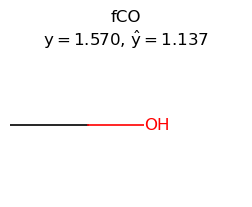

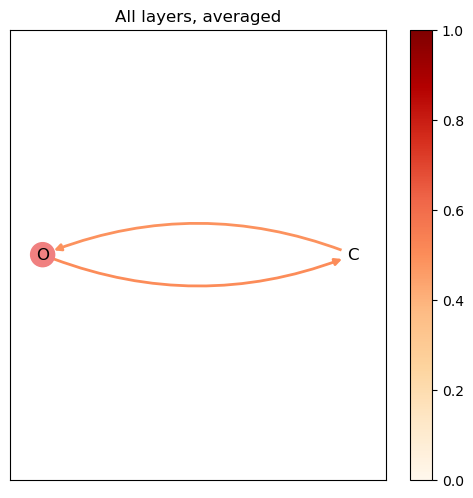

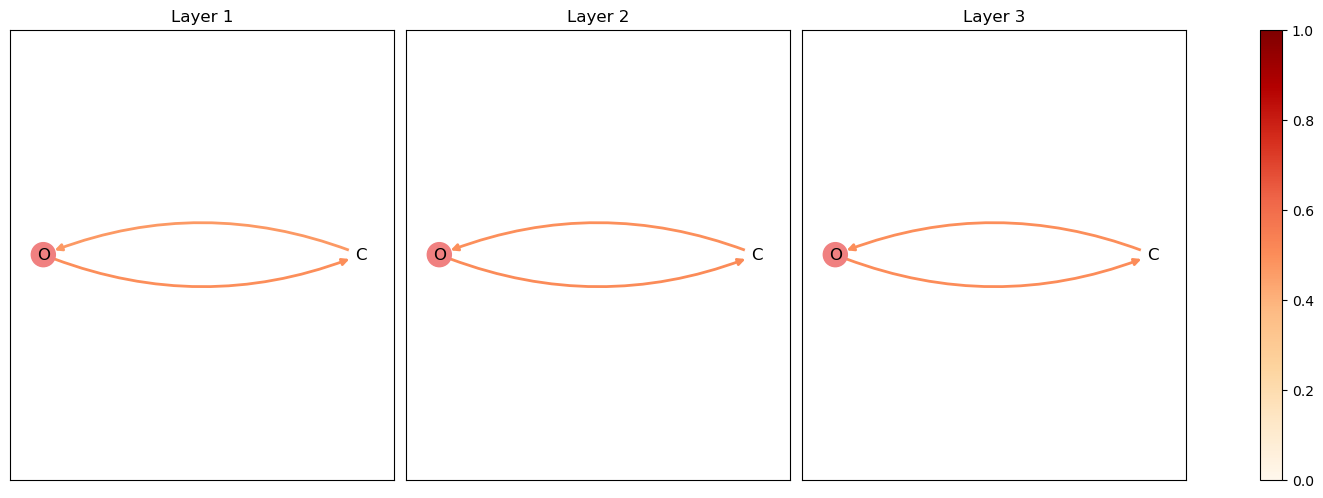

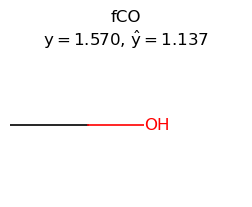

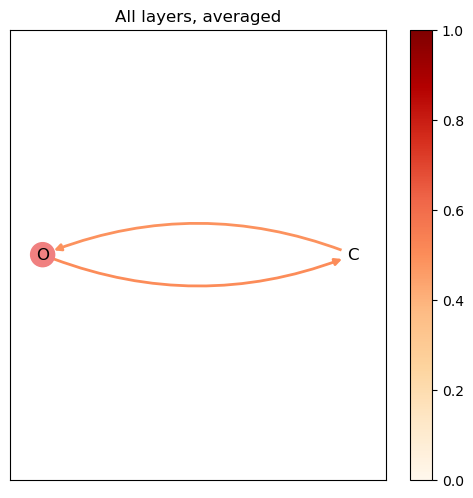

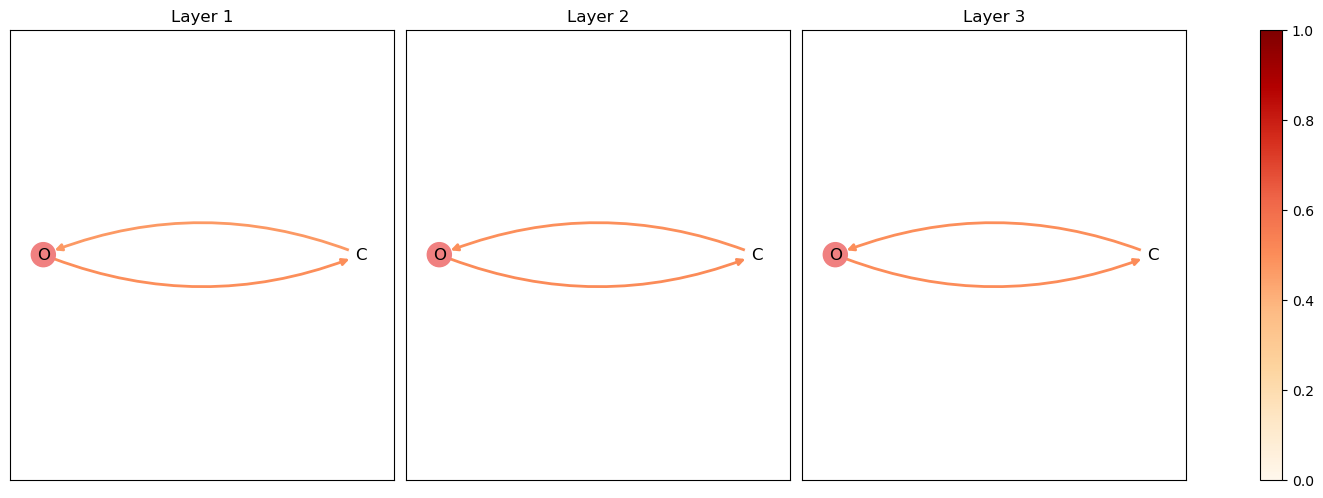

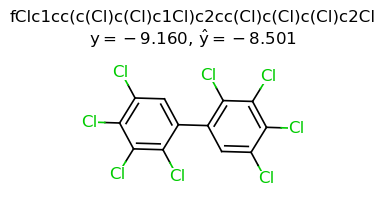

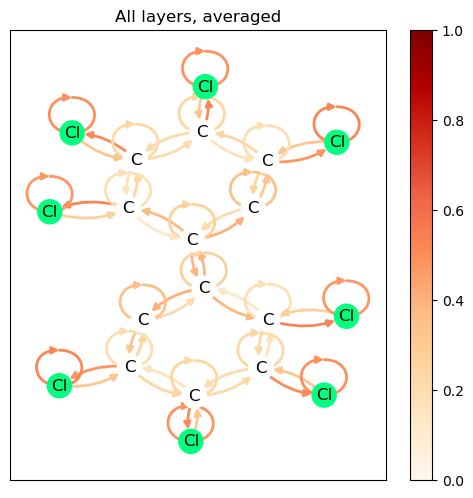

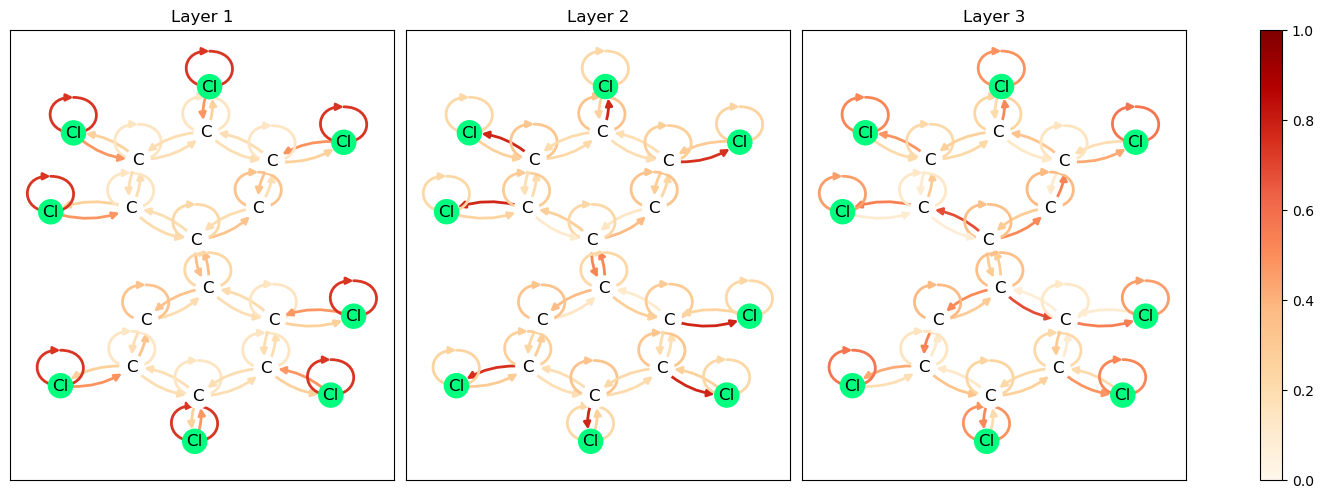

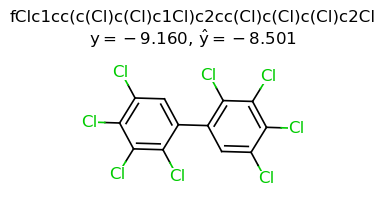

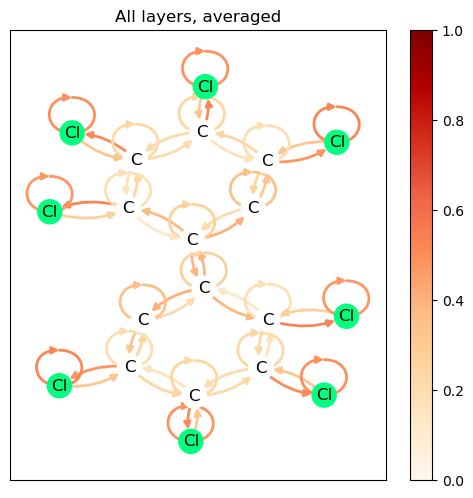

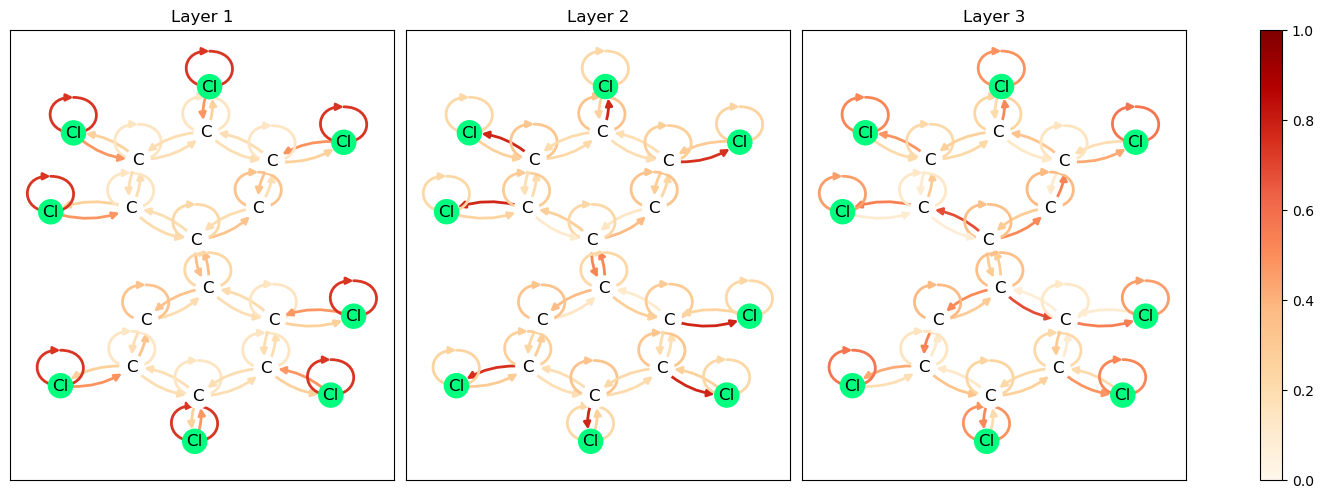

In [422]:
indices_of_interest = [np.argmax(all_y), np.argmax(all_y_pred), np.argmin(all_y), np.argmin(all_y_pred)]

for graph_num in indices_of_interest:
    visualize_attention_map(all_attn[graph_num], all_inputs[graph_num].smiles[0], all_y[graph_num], all_y_pred[graph_num], labels = False, cmap = plt.cm.OrRd)


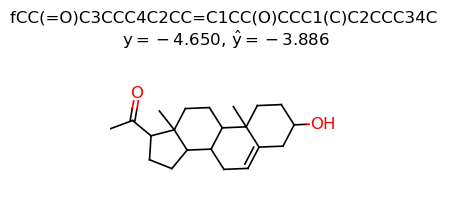

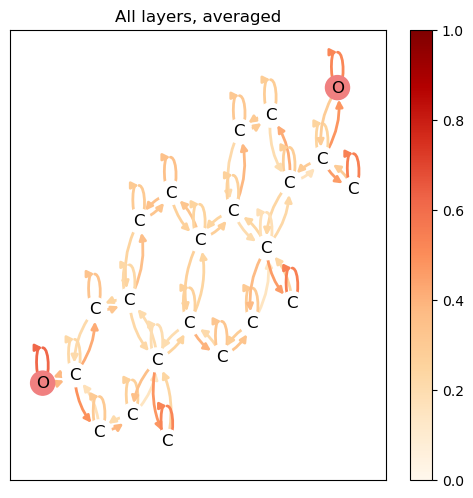

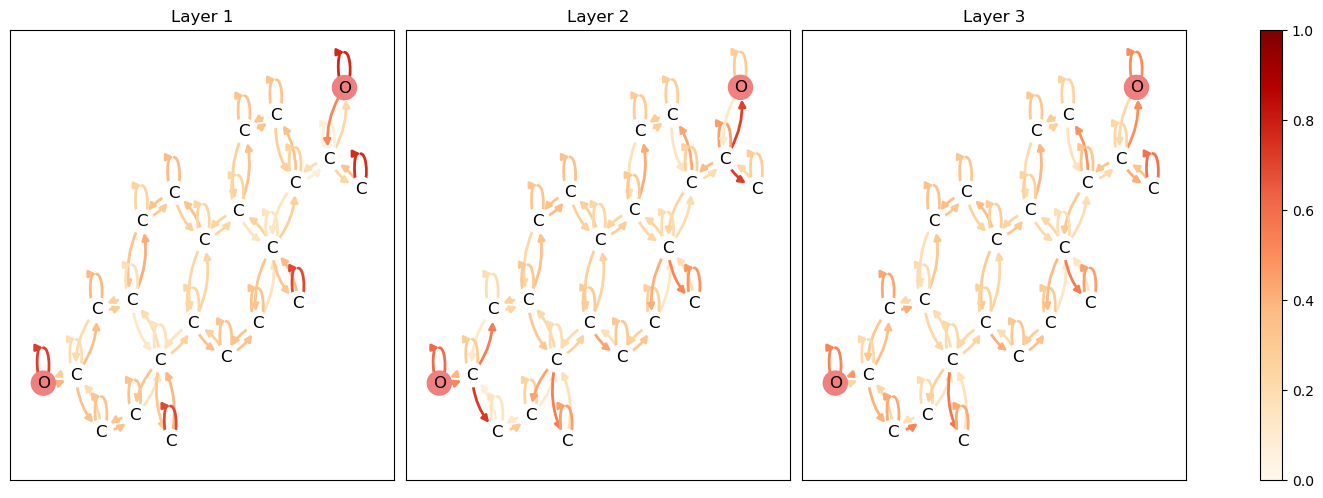

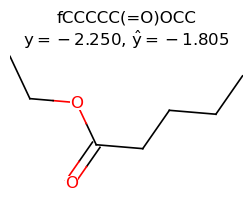

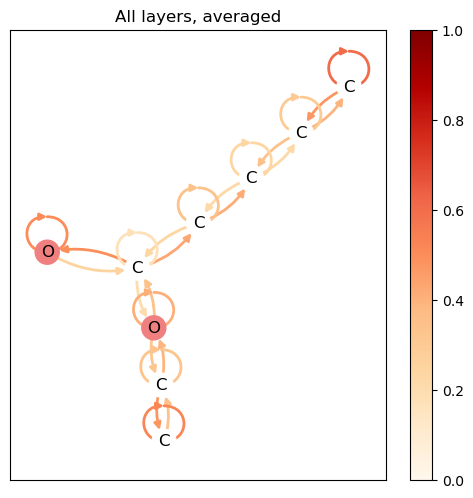

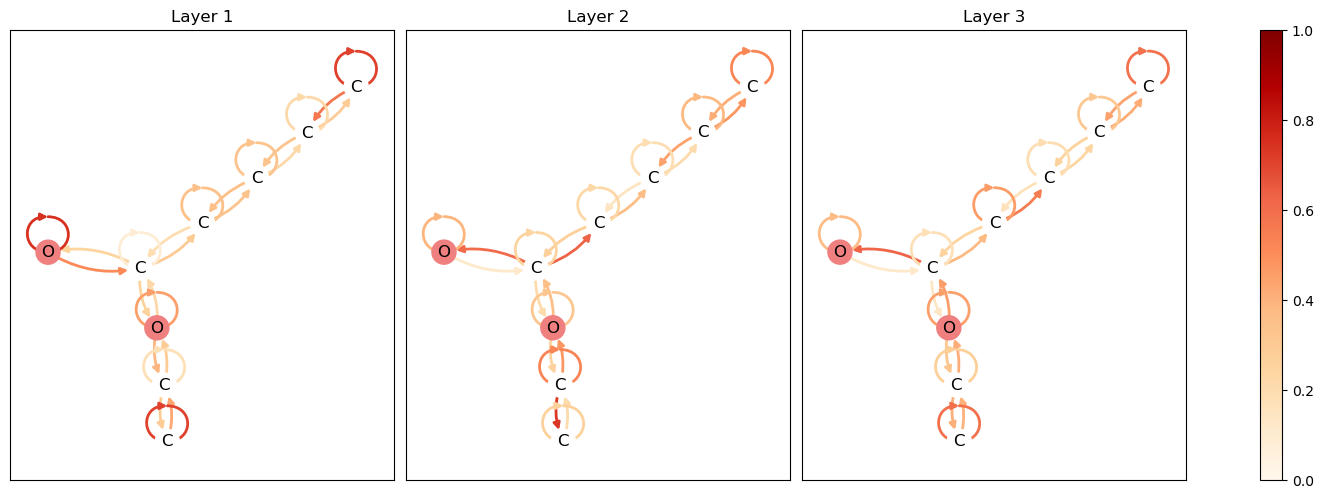

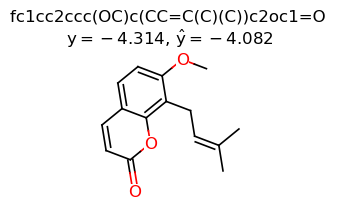

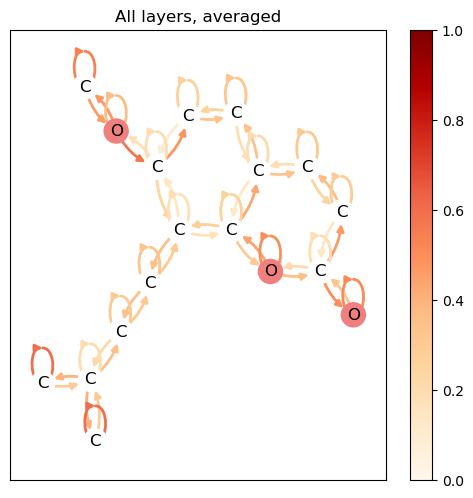

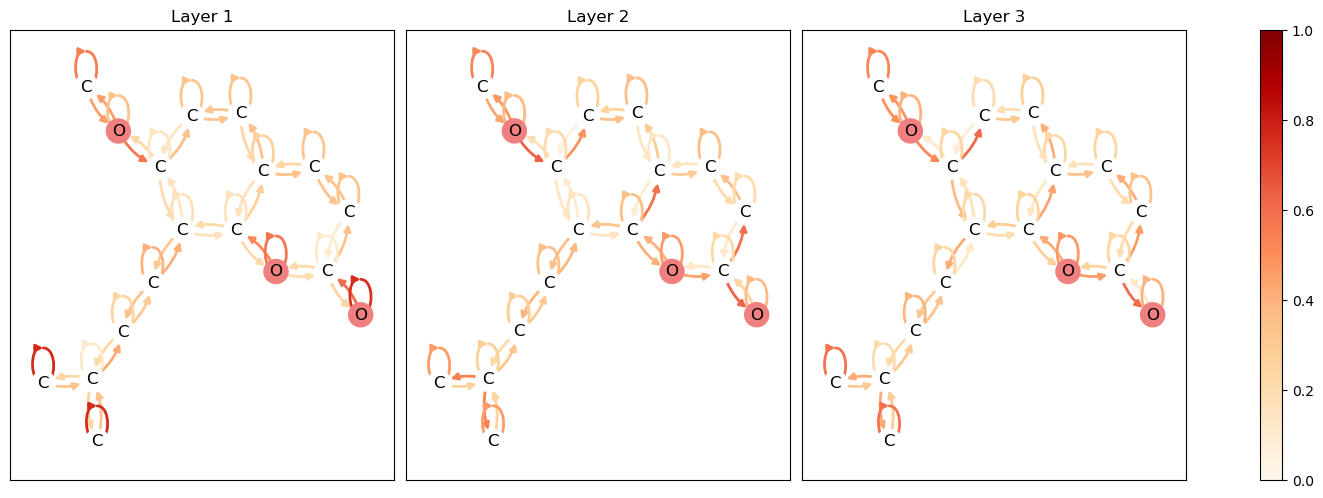

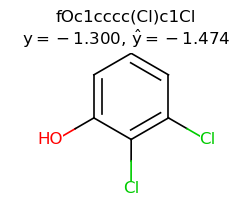

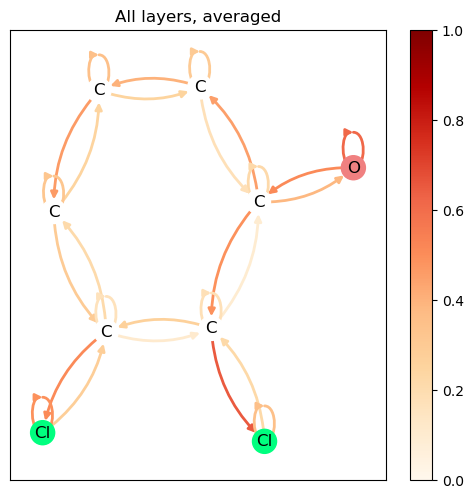

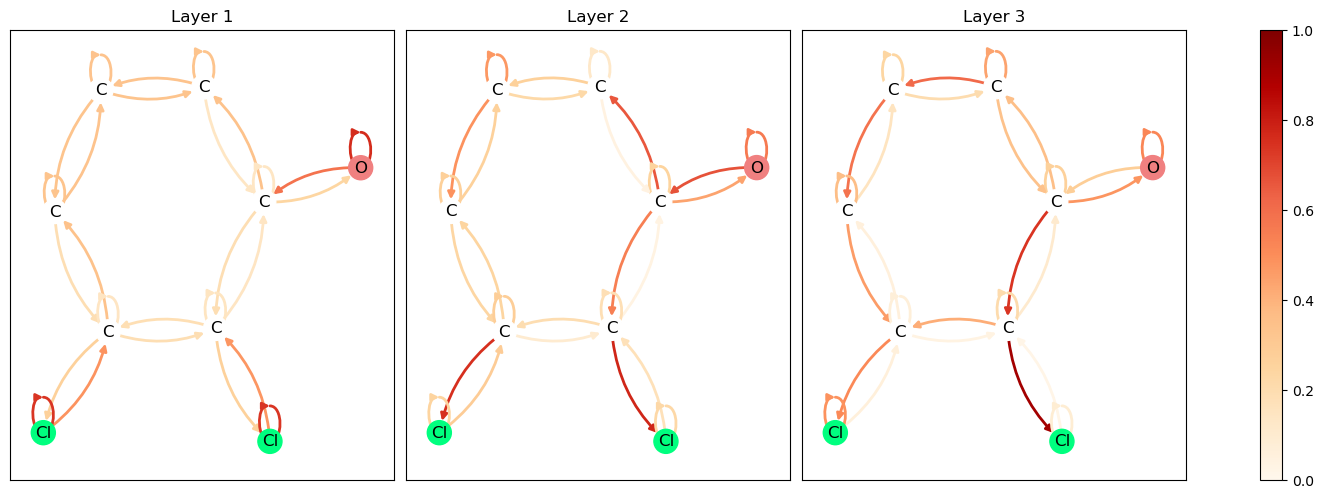

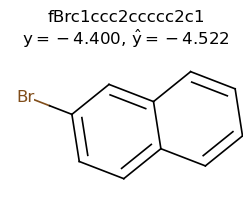

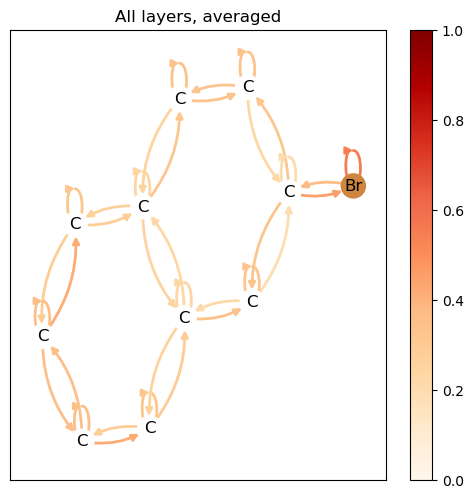

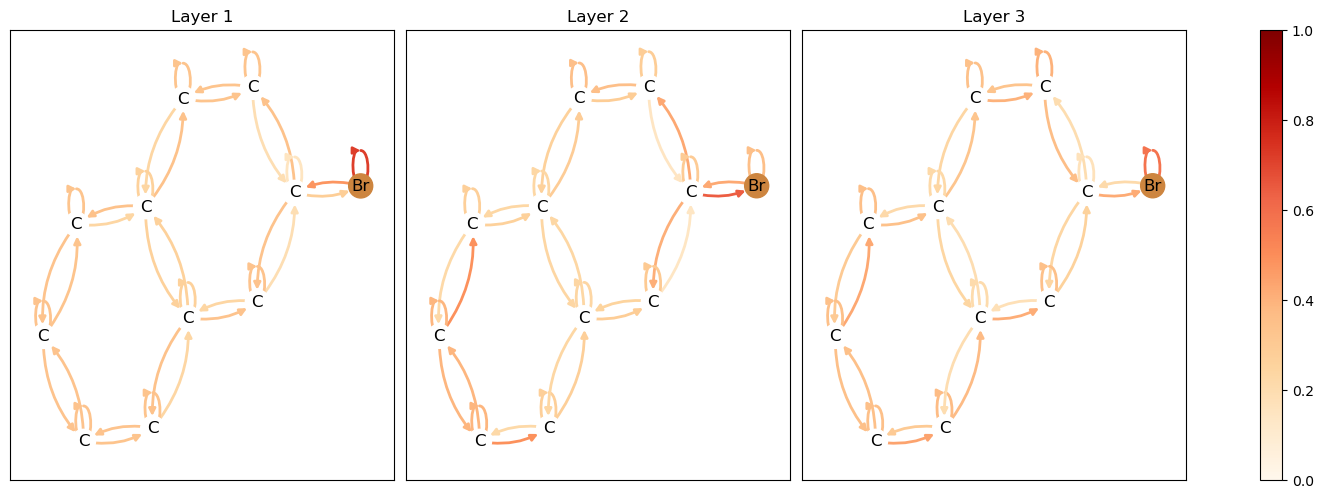

In [423]:
#Random graphs
import random

random_indices = random.sample(range(len(all_y)), 5)

for graph_num in random_indices:
    visualize_attention_map(all_attn[graph_num], all_inputs[graph_num].smiles[0], all_y[graph_num], all_y_pred[graph_num], labels = False, cmap = plt.cm.OrRd)